# GAMINet (Yang et al, 2021)

## Setup

In [1]:
#!nvidia-smi

In [1]:
!source ../ml-env/bin/activate

In [1]:
import wandb
%matplotlib inline

import os
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error
#from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from src.utils import normalize_target
from src.gaminet.gaminet import GAMINet
from src.gaminet.utils import local_visualize
from src.gaminet.utils import global_visualize_density
from src.gaminet.utils import global_visualize_wo_density
from src.gaminet.utils import feature_importance_visualize
from src.gaminet.utils import plot_regularization
from src.gaminet.utils import plot_trajectory

/opt/bwhpc/common/jupyter/tensorflow/2022-03-30/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/opt/bwhpc/common/jupyter/tensorflow/2022-03-30/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/opt/bwhpc/common/jupyter/tensorflow/2022-03-30/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/opt/bwhpc/common/jupyter/tensorflow/2022-03-30/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


### Setup multi-GPU training

In [4]:
#strategy = tf.distribute.MirroredStrategy()
#print('Number of devices: %d' % strategy.num_replicas_in_sync)

In [2]:
wandb.login()
root_path ="./"

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: m-janyellow. Use `wandb login --relogin` to force relogin


## Data preprocessing and modelling methods

In [3]:
def data_splitter(X, y, end_of_training="1985-12-31", end_of_validation="1990-12-31"):
    # define start of training
    start_of_training = X.index.get_level_values(0).min()
   
    # define initial training and test window
    #train_window = pd.date_range(start=start_of_training, end=end_of_training, freq="M")
    #train_window = len(train_window)

    # slice to required size
    X_train = X.loc[pd.IndexSlice[start_of_training:end_of_training,], :]
    y_train = y.loc[pd.IndexSlice[start_of_training:end_of_training,]]
    X_valid = X.loc[pd.IndexSlice[end_of_training:end_of_validation,], :]
    y_valid = y.loc[pd.IndexSlice[end_of_training:end_of_validation,]]
    X_test = X.loc[pd.IndexSlice[end_of_validation:,], :]
    y_test = y.loc[pd.IndexSlice[end_of_validation:,]]
    
    return X_train, X_valid, X_test, y_train, y_valid, y_test


def metric_wrapper(metric, scaler):
    def wrapper(label, pred):
        return metric(label, pred, scaler=scaler)
    return wrapper

def rmse(label, pred, scaler):
    #pred = scaler.inverse_transform(pred.reshape([-1, 1]))
    #label = scaler.inverse_transform(label.reshape([-1, 1]))
    return np.sqrt(np.mean((pred - label)**2))

def mse(label, pred, scaler):
    return mean_squared_error(label, pred)

def mae(label, pred, scaler):
    return mean_absolute_error(label, pred)

##### TO-DO: Scale Input features from 0 to 1 !!
def load_regression_data(pickle=False, feature_selector=[], subsample=False):
    """
    Loads data from data path, as well as scales target y and extracts some meta info, i.e.
    column names and data type (continuous/discrete) before splitting the dataset into
    train and test sets.
    """
    # get and prepare data
    if pickle:
      data = pd.read_pickle(root_path + './data/data_processed_scaled.pkl')
    else:
      dateparse = lambda x: pd.to_datetime(x, format='%Y-%m-%d', errors='coerce')
    if subsample:
       data = pd.read_csv(root_path + './data/subsample_processed_scaled_1000.csv', index_col=["date","permno"],
                           parse_dates=['date'], date_parser=dateparse, skipinitialspace=True)
    else:
        data = pd.read_csv(root_path + './data/data_processed_scaled.csv', index_col=["date","permno"],
                           parse_dates=['date'], date_parser=dateparse, skipinitialspace=True)
    #data = pd.read_csv(root_path + 'data_processed_scaled.csv')
    
    if len(feature_selector) > 0:
      data = data.loc[:,feature_selector]

    # scale target
    scaler_y = StandardScaler()
    target = data.TARGET.values.reshape(-1, 1)
    data['TARGET'] = scaler_y.fit_transform(target)
    
    # isolate target from feature space
    x = data.iloc[:,:-1]
    y = data.TARGET

    task_type = "Regression"
    meta_info = {x.columns[i]:{'type':'continuous'} for i in range(x.shape[1])}
    meta_info.update({'Y':{'type':'target'}})
    #xx = pd.DataFrame(np.zeros((x.shape[0], x.shape[1]), dtype=np.float32))
    # Min-Max Scale target and save scaler for evaluation
    for i, (key, item) in enumerate(meta_info.items()):
        if item['type'] == 'target':
            meta_info[key]['scaler'] = scaler_y
        else:
            sx = MinMaxScaler((0, 1))
            sx.fit([[0], [1]])
            #x[:,[i]] = sx.transform(x[:,[i]])
            meta_info[key]['scaler'] = sx
    train_x, test_x, _, train_y, test_y, _ = data_splitter(x, y)
    train_x, test_x  = train_x.to_numpy(), test_x.to_numpy()
    train_y, test_y = train_y.to_numpy().reshape(-1,1), test_y.to_numpy().reshape(-1,1)
    return train_x, test_x, train_y, test_y, task_type, meta_info, metric_wrapper(rmse, scaler_y), metric_wrapper(mse, scaler_y), metric_wrapper(mae,scaler_y)

## Feature selection 

In [7]:
## best features used by freyberger et al:
#features_freyberger = ['d_shrout', 'd_so', 'investment', 'lme', 'lturnover', 'pm_adj', 'cum_return_1_0', 'cum_return_12_2', 'cum_return_12_7', 'rel_to_high_price', 'roc', 'stock','suv', 'total_vol','TARGET']

### Feature selection by RF
(Markus B.)

In [8]:
## best features found by random forrest reg
#features_rf = ['d_shrout', 'roe', 'oa', 'free_cf', 'nop', 'dpi2a', 'rna', 'ato', 'd_dgm_dsales', 'roc', 'ipm', 'spread_mean', 'dto', 'suv', 'TARGET']

### Features selected by AE

In [9]:
#features_ae = ['e2p', 'beme', 'cum_return_12_2', 'cum_return_12_7', 'mm_sin', 'mm_cos', 'yy', 'dpi2a', 'ret', 'total_vol', 'noa', 'std_volume', 'cto', 'TARGET']

In [10]:
# load preselected data
#train_x, test_x, train_y, test_y, task_type, meta_info, get_rmse, get_mse, get_mae = load_regression_data("crsp")

In [11]:
#train_x.shape

## Training 
- using all features

In [4]:
# load preselected data
train_x, test_x, train_y, test_y, task_type, meta_info, get_rmse, get_mse, get_mae = load_regression_data(subsample=True)

In [5]:
print(f"Size of train set: {train_x.shape}, \n Test set {test_x.shape}")

Size of train set: (64502, 67), 
 Test set (26273, 67)


In [19]:
################## Training ###################
folder = "./models/gaminet/"
if not os.path.exists(folder):
    os.makedirs(folder)

#with strategy.scope():
model = GAMINet(meta_info=meta_info, interact_num=20,
        interact_arch=[40] * 4, subnet_arch=[40] * 4, #*5
        batch_size=256, task_type=task_type, activation_func=tf.nn.relu, # batch=200
        main_effect_epochs=500, interaction_epochs=500, tuning_epochs=250, #ep=5000
        lr_bp=[0.0001, 0.0001, 0.0001], early_stop_thres=[50, 50, 50],
        heredity=True, loss_threshold=0.01, reg_clarity=0.1,
        verbose=True, val_ratio=0.2, random_state=0, model_dir='./models/gaminet/')# , strategy=strategy)

# initialize wandb
wandb.init(project="interpretable-ml", group="gaminet-studies")
wandb.log({"learning_rate" : model.lr_bp, "max_epochs" : model.main_effect_epochs+model.interaction_epochs,
#           #"optimizer" : model.optimizer, 
           "n_features" : train_x.shape[1],
           #"loss_function" : model.loss_fn
           })

model.fit(train_x, train_y)

#wandb.log_artifact(model)

#wandb.log({
           #"maineffect train loss" : model.err_train_main_effect_training [-1],
           #"maineffect val loss" : model.err_val_main_effect_training[-1],
           #"interaction train loss" : model.err_train_interaction_training[-1],
           #"interaction val loss" : model.err_val_interaction_training[-1],
           #"Fine tuning train loss" : model.err_train_tuning[-1],
           #"Fine tuning val loss" : model.err_val_tuning[-1]
#})

data_dict_logs = model.summary_logs(save_dict=False)
plot_trajectory(data_dict_logs, folder=folder, name="125_traj", save_png=True, save_eps=True)
plot_regularization(data_dict_logs, folder=folder, name="125_regu", save_png=True, save_eps=True)

####################GAMI-Net training start.####################
##########Stage 1: main effect training start.##########
Main effects training epoch: 1, train loss: 0.73367, val loss: 0.73837
Main effects training epoch: 6, train loss: 0.72498, val loss: 0.73022
Model is being saved
Main effects training epoch: 11, train loss: 0.72151, val loss: 0.72683
Main effects training epoch: 16, train loss: 0.71837, val loss: 0.72401
Model is being saved
Main effects training epoch: 21, train loss: 0.71601, val loss: 0.72222
Main effects training epoch: 26, train loss: 0.71453, val loss: 0.72127
Model is being saved
Main effects training epoch: 31, train loss: 0.71302, val loss: 0.72064
Main effects training epoch: 36, train loss: 0.71152, val loss: 0.71898
Model is being saved
Main effects training epoch: 41, train loss: 0.71075, val loss: 0.71902
Main effects training epoch: 46, train loss: 0.71052, val loss: 0.71902
Model is being saved
Main effects training epoch: 51, train loss: 0.70838, v

NameError: name 'batch_train_loss' is not defined

In [20]:
# save model summary log
data_dict_logs = model.summary_logs(save_dict=True, folder='models/gaminet/', name='summary_logs_133')

In [15]:
prev_model = pd.read_pickle('models/gaminet/model_interactions.pkl')

In [38]:
# this was an attempt to see the features ranked by importance...
idx = prev_model['active_main_effect_index']
feature_dict = list(meta_info.keys())
print("Main effect importance :", feature_dict[idx])

TypeError: only integer scalar arrays can be converted to a scalar index

## Final model evaluation and interpretability

In [21]:
pred_train = model.predict(train_x)
pred_test = model.predict(test_x)
gaminet_rmse = np.hstack([np.round(get_rmse(train_y, pred_train),5),
                      np.round(get_rmse(test_y, pred_test),5)])
gaminet_mse = np.hstack([np.round(get_mse(train_y, pred_train),5),
                      np.round(get_mse(test_y, pred_test),5)])
gaminet_mae = np.hstack([np.round(get_mae(train_y, pred_train),5),
                      np.round(get_mae(test_y, pred_test),5)])

wandb.log({"rmse_train" : gaminet_rmse[0], "rmse_test" : gaminet_rmse[1],
           "mse_train" : gaminet_mse[0], "mse_test" : gaminet_mse[1],
           "mae_train" : gaminet_mae[0], "mae_test" : gaminet_mae[1]
           })
wandb.finish()

rmse_train = gaminet_rmse[0]
rmse_test = gaminet_rmse[1]
mse_train = gaminet_mse[0]
mse_test = gaminet_mse[1]
mae_train = gaminet_mae[0]
mae_test = gaminet_mae[1]

print('----------- Train performance------------ \n MAE :', mae_train,'\n MSE: ', mse_train, '\n RMSE: ', rmse_train)
print('----------- Test performance------------ \n MAE :', mae_test,'\n MSE: ', mse_test, '\n RMSE: ', rmse_test)

/opt/bwhpc/common/jupyter/tensorflow/2022-03-30/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/opt/bwhpc/common/jupyter/tensorflow/2022-03-30/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/opt/bwhpc/common/jupyter/tensorflow/2022-03-30/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/opt/bwhpc/common/jupyter/tensorflow/2022-03-30/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


Loss test:,█▇▇▇▇▇▇▇▇▇▇▆▅▅▄▄▃▃▃▃▂▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Train Loss,██▇▇▇▇▇▇▇▇▇▆▆▆▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
mae_test,▁
mae_train,▁
max_epochs,▁
mse_test,▁
mse_train,▁
n_features,▁
rmse_test,▁
rmse_train,▁
Loss test:,0.63538


----------- Train performance------------ 
 MAE : 0.55903 
 MSE:  0.60794 
 RMSE:  0.7797
----------- Test performance------------ 
 MAE : 0.65427 
 MSE:  0.89823 
 RMSE:  0.94775


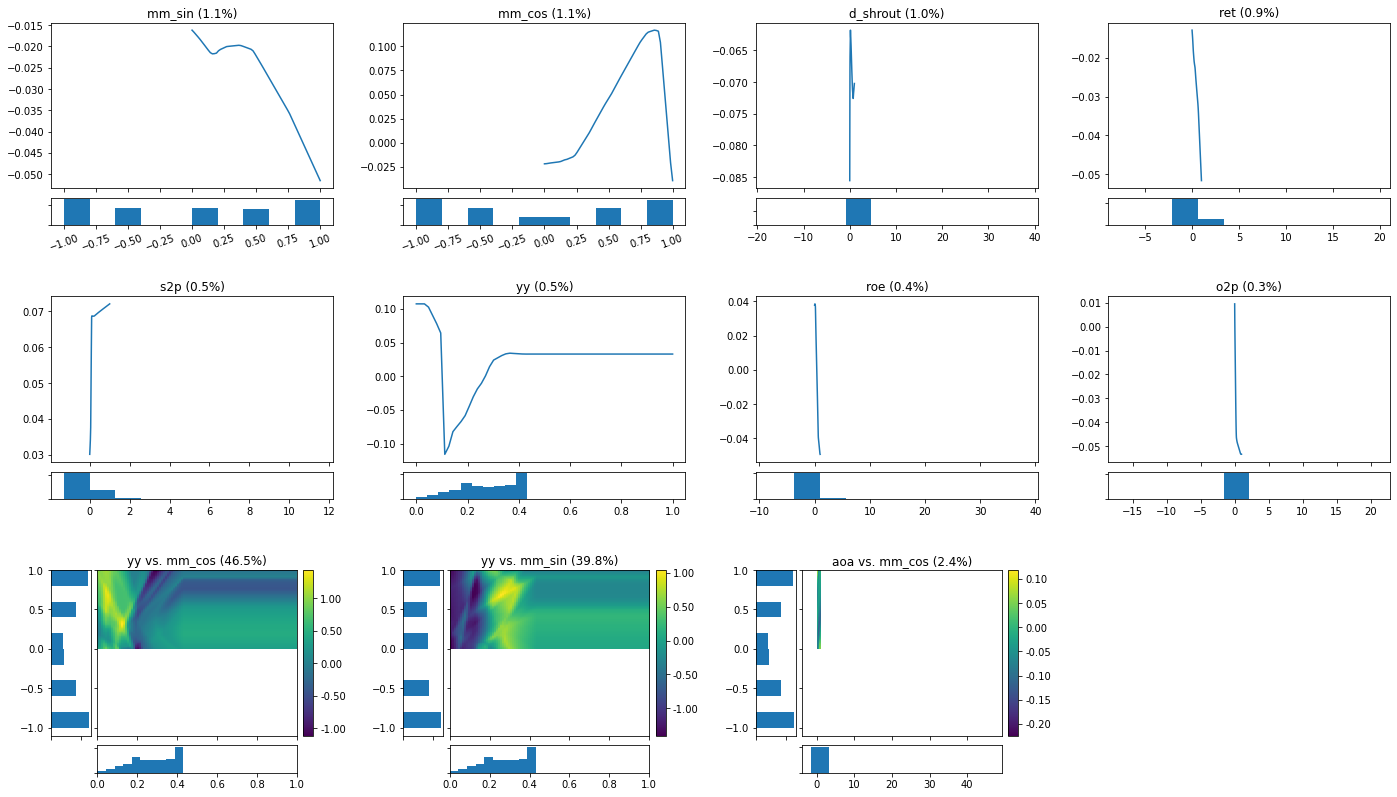

In [28]:
# Plot global explanations
# TO-DO: play around with global_explain's main_grid_size and interact_grid_size arguemnts!
data_dict_global = model.global_explain(save_dict=False, folder=folder, name="explain_global", main_grid_size=64)
global_visualize_density(data_dict_global, folder=folder, name="explain_global",
                         main_effect_num=8, interaction_num=4, cols_per_row=4, save_png=False, save_eps=False)

In [40]:
data_dict_global

{'cum_return_1_0': {'density': {'names': array([-7.54969498, -4.82270924, -2.0957235 ,  0.63126224,  3.35824798,
           6.08523372,  8.81221946, 11.5392052 , 14.26619094, 16.99317668,
          19.72016242]),
   'scores': array([4.97458728e-05, 3.62434216e-03, 2.89222504e-01, 7.18969993e-02,
          1.69846623e-03, 1.77663831e-04, 2.84262130e-05, 0.00000000e+00,
          0.00000000e+00, 7.10655325e-06])},
  'type': 'continuous',
  'importance': 0.0,
  'inputs': array([0.        , 0.01587302, 0.03174603, 0.04761905, 0.06349206,
         0.07936508, 0.0952381 , 0.11111111, 0.12698413, 0.14285714,
         0.15873016, 0.17460317, 0.19047619, 0.20634921, 0.22222222,
         0.23809524, 0.25396825, 0.26984127, 0.28571429, 0.3015873 ,
         0.31746032, 0.33333333, 0.34920635, 0.36507937, 0.38095238,
         0.3968254 , 0.41269841, 0.42857143, 0.44444444, 0.46031746,
         0.47619048, 0.49206349, 0.50793651, 0.52380952, 0.53968254,
         0.55555556, 0.57142857, 0.58730159, 0

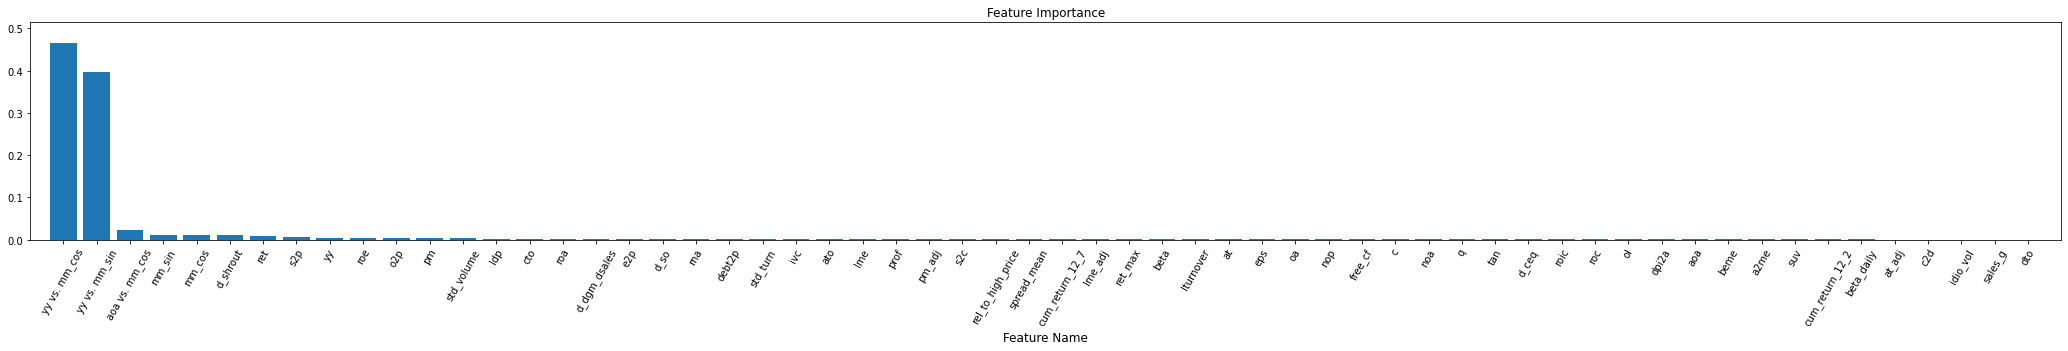

In [26]:
# feature importance plot

feature_importance_visualize(data_dict_global, save_png=False)

In [ ]:
## attempt to reduce importance plot (failed)

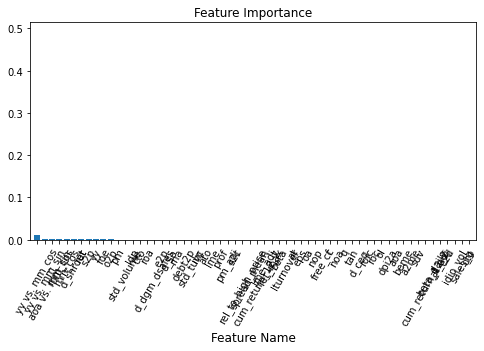

In [57]:
import matplotlib.pyplot as plt
all_ir = []
all_names = []
n = 11 # number features to show +1

for key, item in data_dict_global.items():
    if item["importance"] > 0:
        all_ir.append(item["importance"])
        all_names.append(key)

max_ids = len(all_names)
if max_ids > 0:
    fig = plt.figure(figsize=(8, 4))
    ax = plt.axes()
    ax.bar(np.arange(len(all_ir[:n])), [ir for ir, _ in sorted(zip(all_ir[:n], all_names[:n]))][::-1])
    ax.set_xticks(np.arange(len(all_ir)))
    ax.set_xticklabels([name for _, name in sorted(zip(all_ir, all_names))][::-1], rotation=60)
    plt.xlabel("Feature Name", fontsize=12)
    plt.ylim(0, np.max(all_ir) + 0.05)
    plt.xlim(-1, len(all_names))
    plt.title("Feature Importance")

In [46]:
sorted_ir

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59]),
 [0.010035923701060207,
  0.0023005333004599694,
  0.0021635694287134894,
  0.0016410015929911909,
  0.0015229718421997031,
  0.001074197098615628,
  0.000868273760061787,
  0.0007685875271114591,
  0.0006966984746886025,
  0.000548714822607,
  0.0004075093525633262])

In [24]:
# local explanations
data_dict_local = model.local_explain(test_x[[5]], test_y[[5]], save_dict=False)
local_visualize(data_dict_local[0], save_png=False)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/opt/bwhpc/common/jupyter/tensorflow/2022-03-30/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3369, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/scratch/slurm_tmpdir/job_21023063/ipykernel_1371635/2091408025.py", line 2, in <cell line: 2>
    data_dict_local = model.local_explain(test_x[[5]], test_y[[5]], save_dict=False)
  File "/pfs/data5/home/kit/stud/uvnyg/seminar-interpretable-ml/src/gaminet/gaminet.py", line 864, in local_explain
  File "/pfs/data5/home/kit/stud/uvnyg/seminar-interpretable-ml/src/gaminet/gaminet.py", line 864, in <listcomp>
AttributeError: 'GAMINet' object has no attribute 'active_indice'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/bwhpc/common/jupyter/tensorflow/2022-03-30/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 1982, in showtraceback
    stb = self.InteractiveTB.struc

### Custom global explain w/ Standard Scaled Features

In [31]:
import pickle
with open('data/rank_standard_scaler_x.pkl', 'rb') as f:
    scaler_x = pickle.load(f)
scaler_x

/opt/bwhpc/common/jupyter/tensorflow/2022-03-30/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 1.1.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


date
1963-07-31    StandardScaler()
1963-08-31    StandardScaler()
1963-09-30    StandardScaler()
1963-10-31    StandardScaler()
1963-11-30    StandardScaler()
                    ...       
2013-12-31    StandardScaler()
2014-01-31    StandardScaler()
2014-02-28    StandardScaler()
2014-03-31    StandardScaler()
2014-04-30    StandardScaler()
Length: 610, dtype: object

In [36]:
scaler_x[0].inverse_transform(np.array([1,2]).reshape(1,-1))
# scaler has been saved before some features were removed! Check again in preprocessing notbeook

ValueError: operands could not be broadcast together with shapes (1,2) (78,) (1,2) 

In [9]:
import pickle
model_dir = 'models/gaminet/'

with open(model_dir + 'model_interactions_133.pickle', 'rb') as f:
    model_dict = pickle.load(f)

In [11]:
model_dict.keys()

dict_keys(['meta_info', 'main_effect_weights', 'interaction_weights', 'err_train_main_effect_training', 'err_val_main_effect_training', 'err_train_interaction_training', 'err_val_interaction_training', 'err_train_tuning', 'err_val_tuning', 'interaction_list', 'main_effect_val_loss', 'interaction_val_loss', 'active_main_effect_index', 'active_interaction_index'])